<a href="https://colab.research.google.com/github/ajaysuseel/MiniProject_AD/blob/main/Copy_of_OUT_of_label_hazard_detection_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ----------------------------
# 1. Install & Mount
# ----------------------------
!pip install -q pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv \
    -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install -q torch-geometric spacy pytorch_lightning sentence-transformers transformers
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 99.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6

In [ ]:
# ----------------------------
# 2. Imports & Paths
# ----------------------------
import os, json, torch, networkx as nx
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from PIL import Image
import spacy
import pytorch_lightning as pl
from transformers import BlipProcessor, BlipForConditionalGeneration
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
DRIVE_ROOT        = '/content/drive'
IMAGE_FOLDER      = os.path.join(DRIVE_ROOT, 'MyDrive/Gemini_Captions/kg_test_images')
TEST_JSON         = os.path.join(DRIVE_ROOT, 'MyDrive/Gemini_Captions/kg_test.json')
KG_PATH           = os.path.join(DRIVE_ROOT, 'MyDrive/gemini_models/kg_models2/kg_graph_aug.gpickle')
GNN_WEIGHTS_PATH  = os.path.join(DRIVE_ROOT, 'MyDrive/gemini_models/kg_models2/checkpoints/best_model.pth')
BLIP_CKPT_PATH    = os.path.join(DRIVE_ROOT, 'MyDrive/gemini_models/blip_checkpoints_17_04/blip-epoch=02-val_loss=0.0536.ckpt')
OUTPUT_JSON       = os.path.join(DRIVE_ROOT, 'MyDrive/Gemini_Captions/kg_captions2/final_hazard_predictions_original.json')
DEVICE            = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# ----------------------------
# 3. BLIP Lightning Loader
# ----------------------------
class BlipLightning(pl.LightningModule):
    def __init__(self, model_name="Salesforce/blip-image-captioning-base", learning_rate=5e-5, freeze_vision=True, freeze_layers=6):
        """
        freeze_layers: Freeze vision encoder layers with index less than this value.
        If freeze_vision is True, also freeze vision embeddings.
        """
        super().__init__()
        self.model = BlipForConditionalGeneration.from_pretrained(model_name)
        self.processor = BlipProcessor.from_pretrained(model_name, use_fast=True)
        self.learning_rate = learning_rate

        if freeze_vision:
            # Freeze vision embedding layers (all parameters in vision_model.embeddings)
            for name, param in self.model.named_parameters():
                if "vision_model.embeddings" in name:
                    param.requires_grad = False
                    print(f"Freezing vision embedding parameter: {name}")

            # Freeze early vision encoder layers based on layer index
            for name, param in self.model.named_parameters():
                if "vision_model.encoder.layers" in name:
                    parts = name.split(".")
                    try:
                        layer_index = int(parts[3])
                    except (IndexError, ValueError):
                        layer_index = None
                    if layer_index is not None and layer_index < freeze_layers:
                        param.requires_grad = False
                        print(f"Freezing vision encoder layer {layer_index}: {name}")

    def forward(self, pixel_values, input_ids, attention_mask, labels):
        return self.model(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

    def training_step(self, batch, batch_idx):
        if batch_idx == 0:
            print("Inside training_step, model.training:", self.training)
        outputs = self(
            pixel_values=batch["pixel_values"],
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
        )
        loss = outputs.loss
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)



#load blip finetuned
def load_blip(checkpoint_path):
    lit = BlipLightning.load_from_checkpoint(checkpoint_path)
    lit.to(DEVICE).eval()
    return lit, lit.processor

blip, blip_processor = load_blip(BLIP_CKPT_PATH)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Freezing vision embedding parameter: vision_model.embeddings.class_embedding
Freezing vision embedding parameter: vision_model.embeddings.position_embedding
Freezing vision embedding parameter: vision_model.embeddings.patch_embedding.weight
Freezing vision embedding parameter: vision_model.embeddings.patch_embedding.bias
Freezing vision encoder layer 0: vision_model.encoder.layers.0.self_attn.qkv.weight
Freezing vision encoder layer 0: vision_model.encoder.layers.0.self_attn.qkv.bias
Freezing vision encoder layer 0: vision_model.encoder.layers.0.self_attn.projection.weight
Freezing vision encoder layer 0: vision_model.encoder.layers.0.self_attn.projection.bias
Freezing vision encoder layer 0: vision_model.encoder.layers.0.layer_norm1.weight
Freezing vision encoder layer 0: vision_model.encoder.layers.0.layer_norm1.bias
Freezing vision encoder layer 0: vision_model.encoder.layers.0.mlp.fc1.weight
Freezing vision encoder layer 0: vision_model.encoder.layers.0.mlp.fc1.bias
Freezing vision

In [ ]:
# ----------------------------
# 4. Load KG & Graph Data
# ----------------------------
import pickle
with open(KG_PATH, "rb") as f:
    G = pickle.load(f)

node_to_idx = {n:i for i,n in enumerate(G.nodes())}
deg = dict(G.degree()); max_deg = max(deg.values()) or 1
edge_index = torch.tensor([[node_to_idx[u] for u,v in G.edges()],
                           [node_to_idx[v] for u,v in G.edges()]], dtype=torch.long)
x_feat = torch.tensor([[deg[n]/max_deg] for n in G.nodes()], dtype=torch.float)
data_graph = Data(x=x_feat, edge_index=edge_index).to(DEVICE)

In [ ]:
# ----------------------------
# 5. NLP Setup & Scoring
# ----------------------------
nlp = spacy.load('en_core_web_sm')
embedder = SentenceTransformer('all-MiniLM-L6-v2')

hazard_keywords = {
    "low": [
        ("clear road", 1.0), ("dry road", 1.0), ("daytime", 1.0), ("straight road", 1.0),
        ("good visibility", 1.0), ("no traffic", 1.0), ("open road", 1.0), ("well-lit", 1.0),
        ("sunny", 1.0), ("flat terrain", 1.0), ("light traffic", 1.0), ("wide road", 1.0)
    ],
    "medium": [
        ("moderate visibility", 1.5), ("residential area", 1.5), ("curved road", 1.5),
        ("slightly wet", 1.5), ("light rain", 1.5), ("children nearby", 1.5),
        ("cyclist", 1.5), ("school zone", 1.5), ("urban traffic", 1.5),
        ("construction zone", 1.6), ("intersections", 1.6), ("speed bumps", 1.5)
    ],
    "high": [
        ("poor visibility", 2.0), ("fog", 2.0), ("heavy rain", 2.1), ("pedestrian ahead", 2.2),
        ("jaywalking", 2.2), ("nighttime", 2.0), ("icy road", 2.3), ("sharp turn", 2.1),
        ("blind spot", 2.1), ("narrow lane", 2.0), ("heavy traffic", 2.0),
        ("obstruction", 2.1), ("collision", 2.5), ("emergency vehicle", 2.2), ("road closed", 2.3)
    ]
}

def extract_triplets(text):
    doc = nlp(text.lower())
    triples = []
    for t in doc:
        if t.dep_ in ("amod","acomp") and t.head.pos_=="NOUN":
            triples.append((t.head.lemma_, t.lemma_))
        elif t.dep_=="attr" and t.head.pos_=="NOUN":
            triples.append((t.head.lemma_, t.lemma_))
        elif t.dep_=="nsubj" and t.head.pos_ in ("VERB","AUX"):
            triples.append((t.text, t.head.lemma_))
    return triples

def keyword_hazard_score(text):
    txt = text.lower()
    return torch.tensor([
        sum(txt.count(kw)*w for kw,w in hazard_keywords[lvl])
        for lvl in ("low","medium","high")
    ], dtype=torch.float)

def graph_context_score(text):
    nodes = {u for u,_ in extract_triplets(text)} | {v for _,v in extract_triplets(text)}
    vals = [deg[n]/max_deg for n in nodes if n in deg]
    m = float('nan') if not vals else sum(vals)/len(vals)
    return torch.tensor([m]*3, dtype=torch.float)

def semantic_score(text):
    emb = embedder.encode(text, convert_to_tensor=True)
    sims = []
    for lvl in ("low","medium","high"):
        kws = [kw for kw,_ in hazard_keywords[lvl]]
        kws_emb = embedder.encode(kws, convert_to_tensor=True)
        sims.append(util.cos_sim(emb, kws_emb).max().item())
    total = sum(sims) or 1.0
    return torch.tensor([s/total for s in sims], dtype=torch.float)

def compute_features(text):
    return torch.cat([
        keyword_hazard_score(text),
        graph_context_score(text),
        semantic_score(text)
    ]).unsqueeze(0)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:

# 6. Define and Load Model
class GraphSAGEClassifier(nn.Module):
    def __init__(self, in_c, hidden_c, out_c, dropout=0.3):
        super().__init__()
        self.sage1 = SAGEConv(in_c, hidden_c)
        self.sage2 = SAGEConv(hidden_c, hidden_c)
        self.sage3 = SAGEConv(hidden_c, hidden_c)
        self.attn_weights = nn.Parameter(torch.randn(hidden_c,1))
        self.mlp = nn.Sequential(
            nn.Linear(hidden_c + 9, 64), nn.LayerNorm(64), nn.ReLU(),
            nn.Dropout(dropout), nn.Linear(64, out_c)
        )
    def forward(self, node_ids_batch, heuristics, graph):
        x, edge_index = graph.x, graph.edge_index
        x = self.sage1(x, edge_index).relu()
        x = self.sage2(x, edge_index).relu()
        x = self.sage3(x, edge_index).relu()
        node_feats = []
        for node_ids in node_ids_batch:
            embeds = x[node_ids]
            scores = embeds @ self.attn_weights
            attn = torch.softmax(scores, dim=0)
            node_feats.append((attn * embeds).sum(dim=0))
        graph_feats = torch.stack(node_feats)
        combined = torch.cat([graph_feats, heuristics.to(DEVICE)], dim=1)
        return self.mlp(combined)

gnn = GraphSAGEClassifier(1,128,3).to(DEVICE)
gnn.load_state_dict(torch.load(GNN_WEIGHTS_PATH, map_location=DEVICE))
gnn.eval()


GraphSAGEClassifier(
  (sage1): SAGEConv(1, 128, aggr=mean)
  (sage2): SAGEConv(128, 128, aggr=mean)
  (sage3): SAGEConv(128, 128, aggr=mean)
  (mlp): Sequential(
    (0): Linear(in_features=137, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [ ]:

# ----------------------------
# 7. Load Ground Truth
# ----------------------------
with open(TEST_JSON) as f:
    test_meta = {it["filename"]: it for it in json.load(f)}

# # ----------------------------
# # 8. Inference Loop
# # ----------------------------
# results, true_labels, pred_labels = [], [], []
# for fname in tqdm(os.listdir(IMAGE_FOLDER), desc="Images"):
#     if not fname.lower().endswith(('.jpg','.png','.jpeg')):
#         continue
#     img = Image.open(os.path.join(IMAGE_FOLDER, fname)).convert("RGB")

#     # a) BLIP caption
#     inp = blip_processor(images=img, return_tensors="pt").to(DEVICE)
#     out_ids = blip.model.generate(**inp, max_new_tokens=50)
#     caption = blip_processor.decode(out_ids[0], skip_special_tokens=True)

#     # b) Features & node extraction
#     feat = compute_features(caption)
#     trip = extract_triplets(caption)
#     nodes = [node_to_idx[n] for u,v in trip for n in (u,v) if n in node_to_idx]
#     if not nodes: nodes = [0]

#     # c) GNN inference
#     with torch.no_grad():
#         out = gnn([nodes], feat, data_graph)
#         lab = out.argmax(1).item()
#     rating = ["low","medium","high"][lab]

#     # d) Record
#     gt = test_meta.get(fname, {}).get("hazard_rating")
#     results.append({
#         "filename": fname,
#         "ground_truth": gt,
#         "caption": caption,
#         "predicted_rating": rating
#     })
#     if gt is not None:
#         true_labels.append(gt)
#         pred_labels.append(rating)

from tqdm import tqdm
from PIL import Image
import os

# ----------------------------
# 8. Optimized Inference Loop
# ----------------------------
results, true_labels, pred_labels = [], [], []

image_files = [f for f in os.listdir(IMAGE_FOLDER) if f.lower().endswith(('.jpg','.png','.jpeg'))]

with torch.no_grad():
    for fname in tqdm(image_files, desc="🔍 Inference"):
        img_path = os.path.join(IMAGE_FOLDER, fname)
        img = Image.open(img_path).convert("RGB")

        # a) BLIP captioning
        inp = blip_processor(images=img, return_tensors="pt").to(DEVICE, non_blocking=True)
        out_ids = blip.model.generate(**inp, max_new_tokens=50)
        caption = blip_processor.decode(out_ids[0], skip_special_tokens=True)

        # b) Features + Graph Nodes
        feat = compute_features(caption)  # Already returns torch.tensor
        trip = extract_triplets(caption)
        nodes = [node_to_idx[n] for u, v in trip for n in (u, v) if n in node_to_idx]
        if not nodes:
            nodes = [0]  # fallback to default node

        # c) GNN Inference
        out = gnn([nodes], feat, data_graph)
        lab = out.argmax(1).item()
        rating = ["low", "medium", "high"][lab]

        # d) Store Result
        gt = test_meta.get(fname, {}).get("hazard_rating")
        results.append({
            "filename": fname,
            "ground_truth": gt,
            "caption": caption,
            "predicted_rating": rating
        })
        if gt is not None:
            true_labels.append(gt)
            pred_labels.append(rating)


# ----------------------------
# 9. Save JSON
# ----------------------------
with open(OUTPUT_JSON, "w") as f:
    json.dump(results, f, indent=2)
print(f"✅ Saved {len(results)} records to {OUTPUT_JSON}")

🔍 Inference: 100%|██████████| 1539/1539 [15:28<00:00,  1.66it/s]

✅ Saved 1539 records to /content/drive/MyDrive/Gemini_Captions/kg_captions2/final_hazard_predictions_original.json



Classification Report:

              precision    recall  f1-score   support

         low       0.57      0.20      0.30       587
      medium       0.27      0.16      0.20       146
        high       0.55      0.85      0.67       806

    accuracy                           0.54      1539
   macro avg       0.46      0.40      0.39      1539
weighted avg       0.53      0.54      0.48      1539



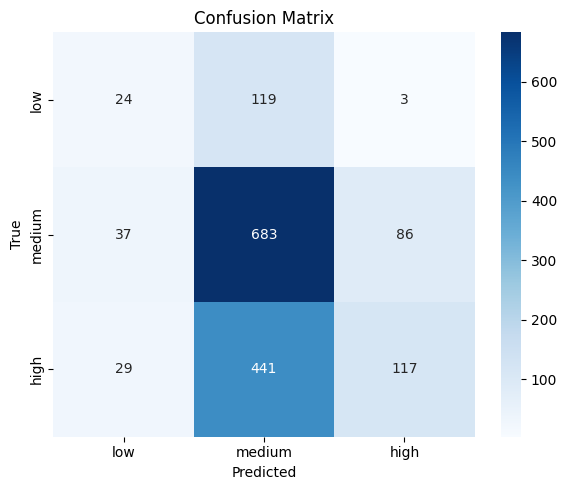

In [ ]:

# ----------------------------
# 10. Evaluate & Plot
# ----------------------------
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=["low","medium","high"]))

cm = confusion_matrix(true_labels, pred_labels, labels=["low","medium","high"])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["low","medium","high"],
            yticklabels=["low","medium","high"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


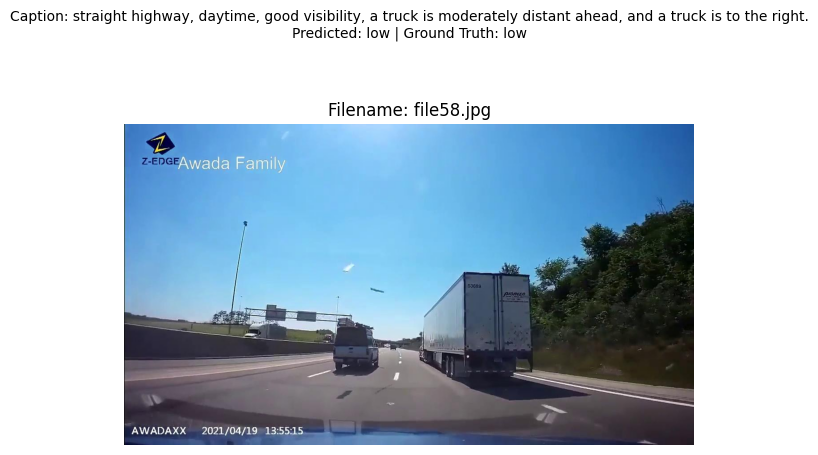

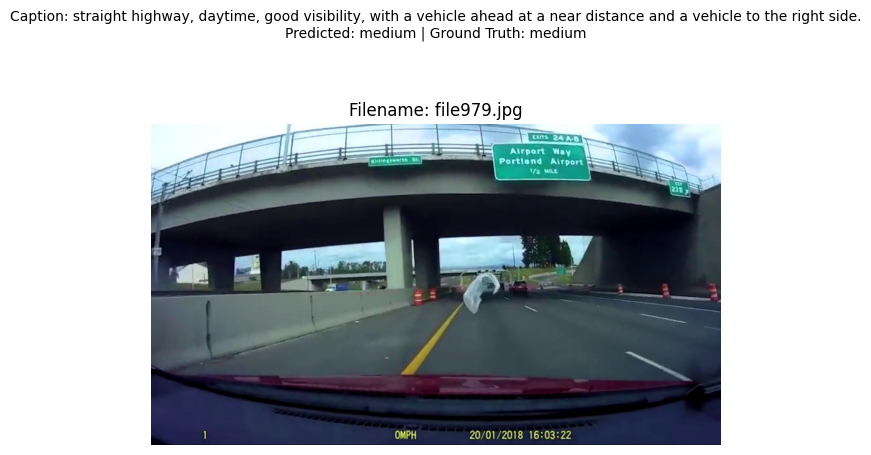

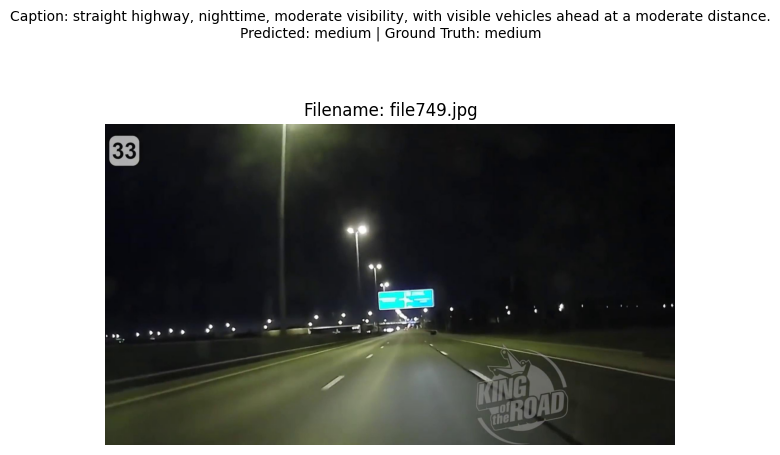

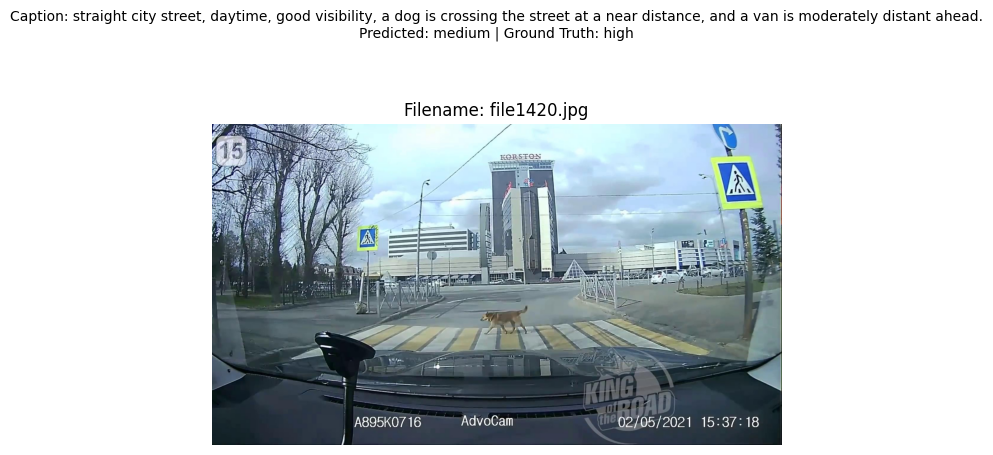

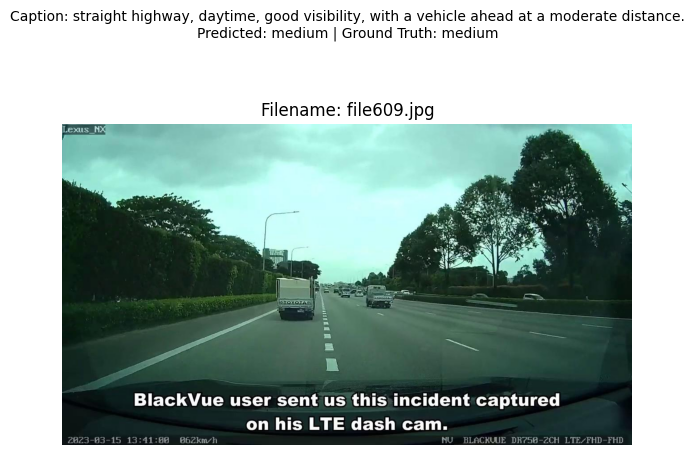

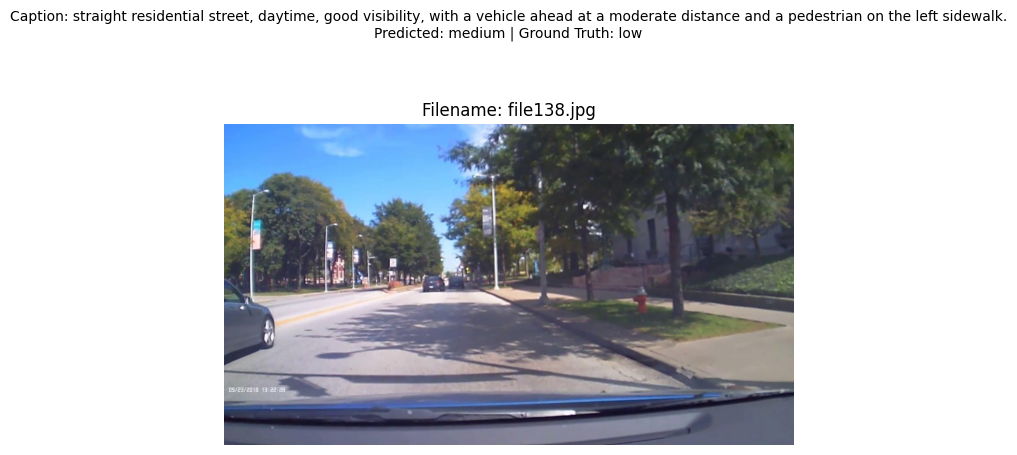

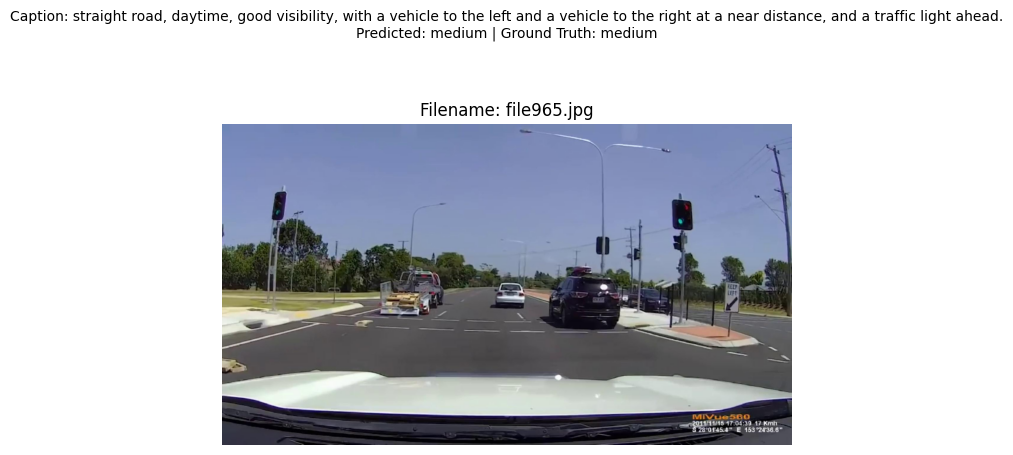

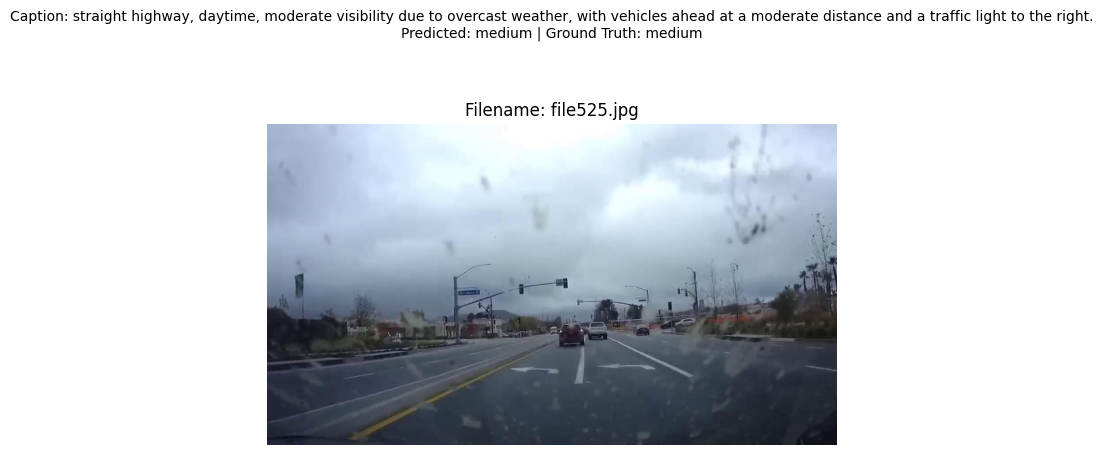

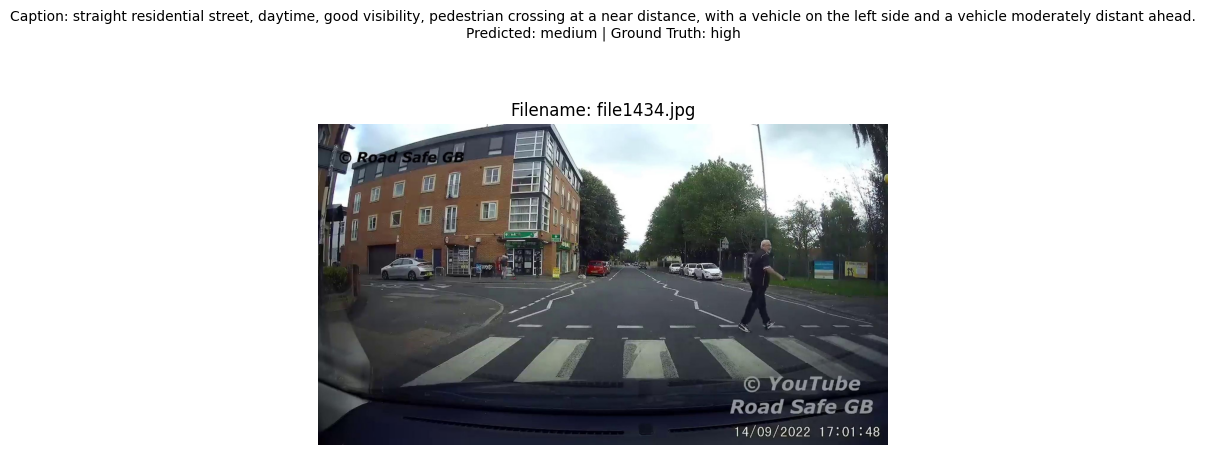

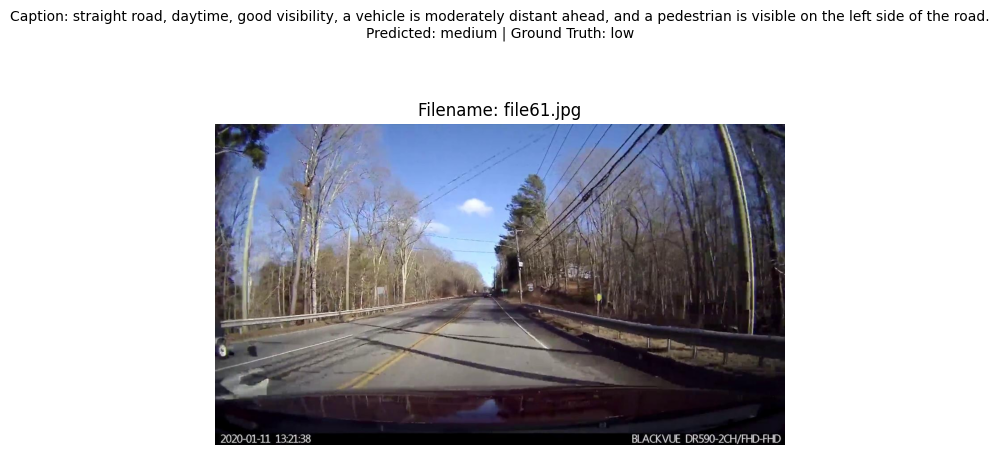

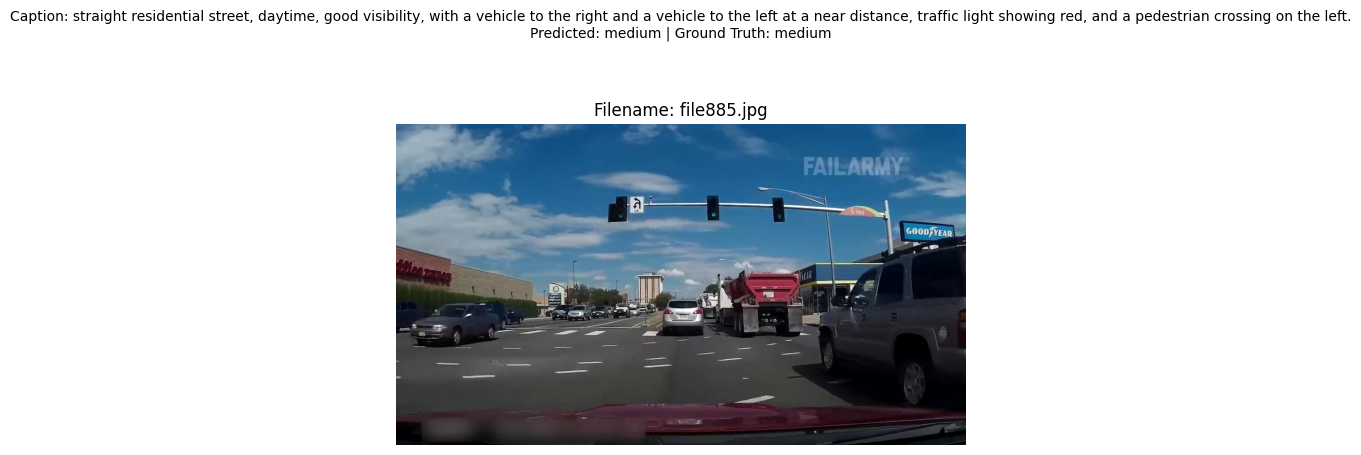

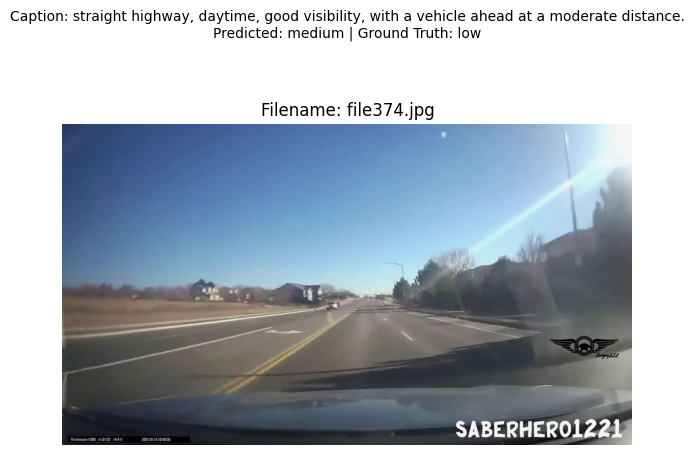

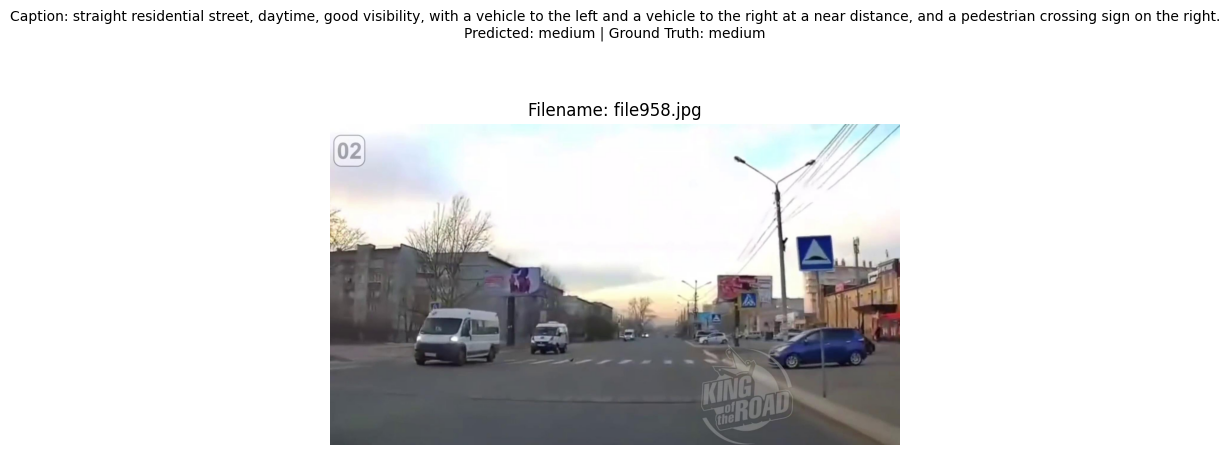

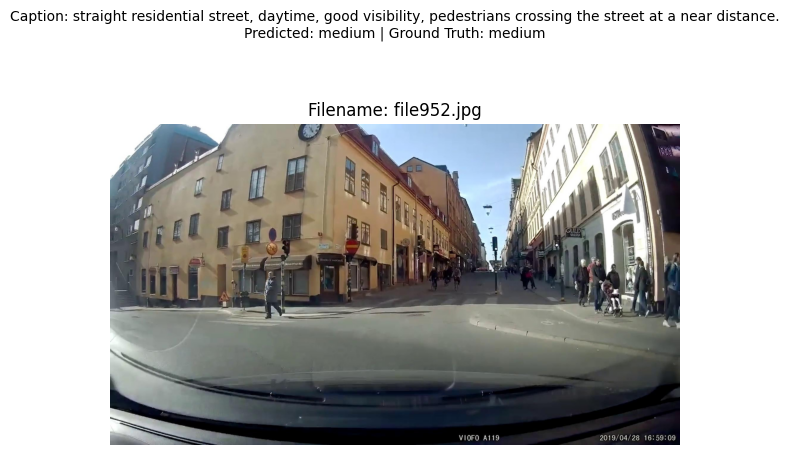

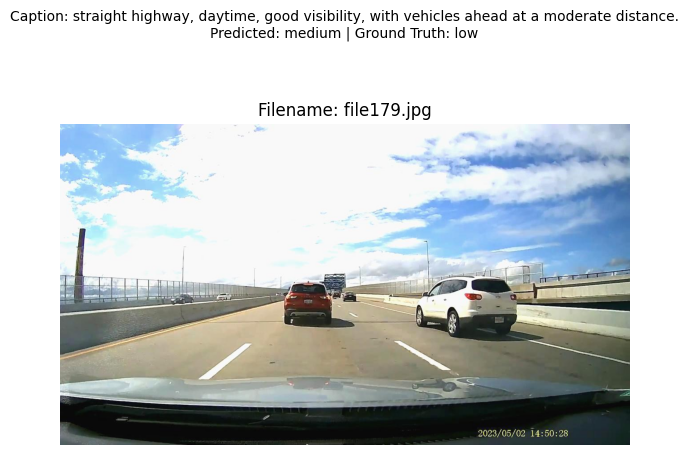

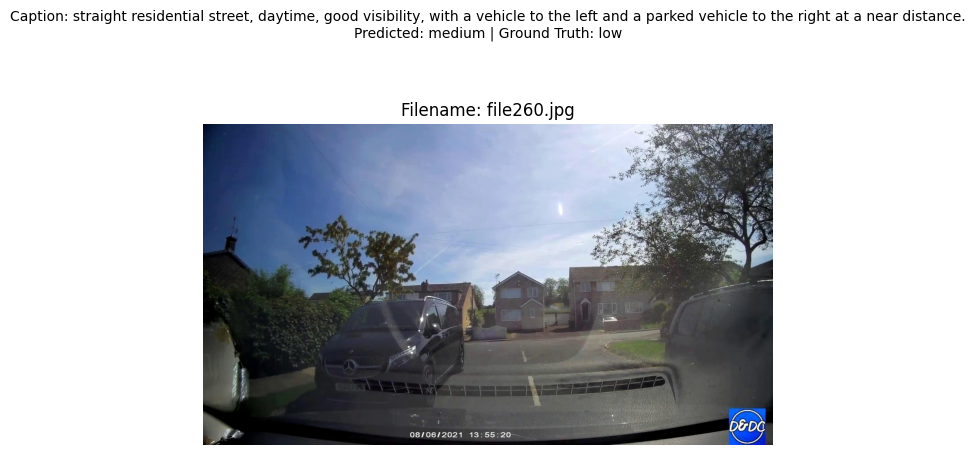

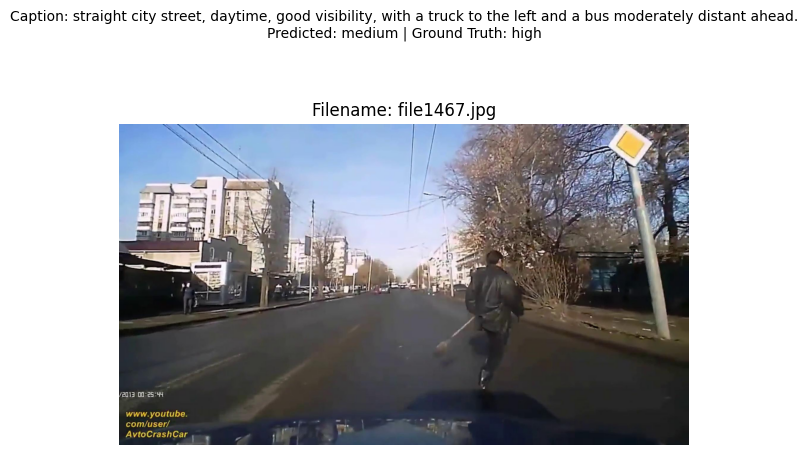

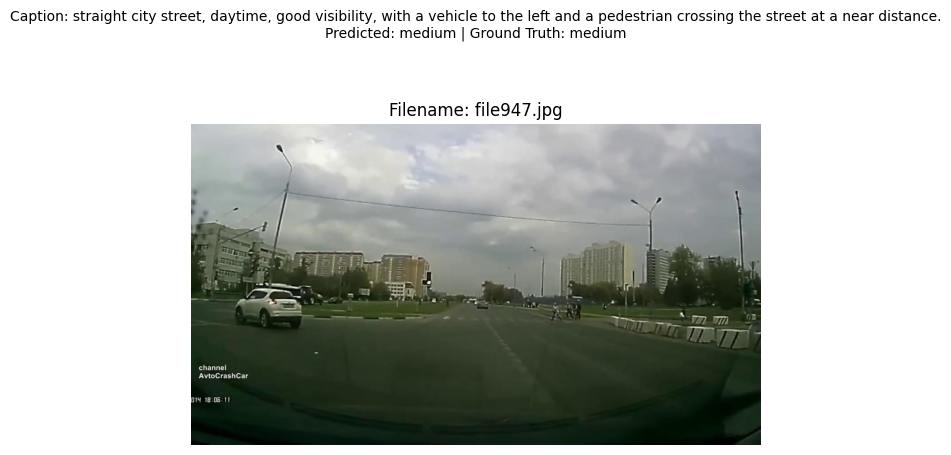

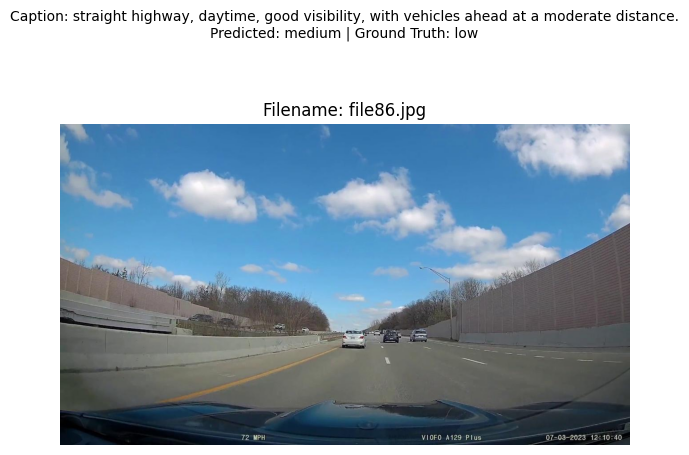

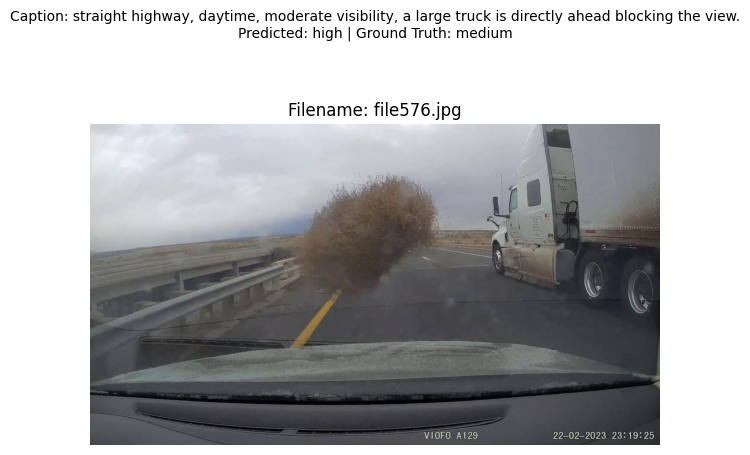

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

def show_random_results(results, image_folder, num_samples=5):
    """
    Randomly displays a number of images with their caption, prediction, and ground truth.

    Args:
        results (list): List of dicts with keys 'filename', 'caption', 'predicted_rating', 'ground_truth'.
        image_folder (str): Path to folder containing the images.
        num_samples (int): Number of samples to display.
    """
    sampled = random.sample(results, min(num_samples, len(results)))

    for res in sampled:
        img_path = os.path.join(image_folder, res['filename'])
        if not os.path.exists(img_path):
            print(f"⚠️ Image not found: {img_path}")
            continue
        img = Image.open(img_path).convert("RGB")

        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Filename: {res['filename']}", fontsize=12)
        plt.suptitle(f"Caption: {res['caption']}\n"
                     f"Predicted: {res['predicted_rating']} | "
                     f"Ground Truth: {res.get('ground_truth', 'N/A')}",
                     fontsize=10, y=0.92)
        plt.tight_layout()
        plt.show()

show_random_results(results, IMAGE_FOLDER, num_samples=20)